In [1]:
import pandas as pd
import numpy as np
import random
import shap
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('../')
from modules import utils, constants
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize, LabelBinarizer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report 
from sklearn.metrics import roc_curve, auc

In [2]:
SEED = constants.SEED
random.seed(SEED)
np.random.seed(SEED)

#### Reading and splitting the dataset

In [3]:
#train_df = pd.read_csv('../data/train_set_basic.csv')
# train_df = pd.read_csv('../data/18_jan/train_set_basic.csv')
train_df = pd.read_csv('../data/inconclusive_diagnosis/missingness/0/training_set.csv')
# val_df = pd.read_csv('../data/noisiness/0.1/validation_set.csv')
# # train_df = pd.concat([train_df_orig, val_df]).reset_index(drop=True)
train_df = train_df.fillna(-1)
X_train = train_df.iloc[:, 0:-1]
y_train = train_df.iloc[:, -1]
X_train.head()
#train_df.label.value_counts()

,ana,fever,leukopenia,thrombocytopenia,auto_immune_hemolysis,delirium,psychosis,seizure,non_scarring_alopecia,oral_ulcers,...,acute_pericarditis,joint_involvement,proteinuria,anti_cardioliphin_antibodies,anti_β2gp1_antibodies,lupus_anti_coagulant,low_c3,low_c4,anti_dsdna_antibody,anti_smith_antibody
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,...,0.0,1.0,-1.0,0.0,0.0,-1.0,0.0,0.0,1.0,0.0
3,1,0.0,1.0,1.0,0.0,1.0,1.0,-1.0,0.0,1.0,...,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0
4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [4]:
# test_df = pd.read_csv('../data/18_jan/test_set_basic.csv')
test_df = pd.read_csv('../data/inconclusive_diagnosis/missingness/0/testing_set.csv')
X_test = test_df.iloc[:, 0:-1]
y_test = test_df.iloc[:, -1]
X_test.head()
#test_df.label.value_counts()

,ana,fever,leukopenia,thrombocytopenia,auto_immune_hemolysis,delirium,psychosis,seizure,non_scarring_alopecia,oral_ulcers,...,acute_pericarditis,joint_involvement,proteinuria,anti_cardioliphin_antibodies,anti_β2gp1_antibodies,lupus_anti_coagulant,low_c3,low_c4,anti_dsdna_antibody,anti_smith_antibody
0,1,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,-1.0,0.0,...,0.0,-1.0,0.0,-1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,-1.0,0.0,0.0,-1.0,0.0,-1.0,0.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0
4,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0


In [5]:
# X_train, y_train = np.array(X_train), np.array(y_train)
# X_test, y_test = np.array(X_test), np.array(y_test)
# X_train.shape, X_test.shape, y_train.shape, y_test.shape

#### Decision Tree

In [6]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
dt = DecisionTreeClassifier(random_state=constants.SEED).fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
test_df_dt = pd.DataFrame()
test_df_dt['y_actual'] = y_test
test_df_dt['y_pred'] = y_pred_dt
test_df_dt.isna().sum()

y_actual    0
y_pred      0
dtype: int64

In [7]:
# acc_dt, prec_dt, recall_dt, f1_dt = utils.test_binary(test_df_dt['y_actual'], test_df_dt['y_pred'])
# acc_dt, prec_dt, recall_dt, f1_dt

In [8]:
acc_dt2, f1_dt2, roc_auc_dt2 = utils.test(test_df_dt['y_actual'], test_df_dt['y_pred'])
acc_dt2, f1_dt2, roc_auc_dt2

(95.15714285714286, 94.19697616398196, 95.77425756304966)

In [9]:
#from sklearn import tree
#fig = plt.figure(figsize=(25,20))
#_ = tree.plot_tree(dt, 
#                   feature_names=X_train.columns,  
#                   class_names=['no lupus', 'lupus'],
#                   filled=True)
#fig.savefig('../images/dt_basic.png')

In [10]:
# import graphviz
# dot_data = export_graphviz(dt, out_file=None, 
#                                 feature_names= X_train.columns,  
#                                 class_names=['no lupus', 'lupus'],
#                                 filled=True)


# graph = graphviz.Source(dot_data, format='png') 
# #graph
# Convert to image using dot -Tpng images/dt_basic.dot -o images/dt_basic.png 
# Make sure to have graphviz installed (windows executable file like normal software)

##### Feature importance

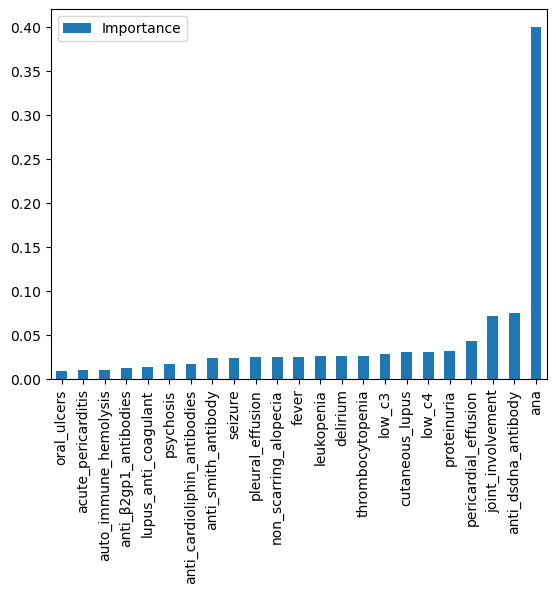

In [11]:
utils.compute_feature_importance(dt, X_train)

##### SHAP

In [12]:
explainer = shap.TreeExplainer(dt)
shap_values = explainer.shap_values(X_test)
len(shap_values)

3

In [13]:
shap_values[0].shape

(14000, 23)

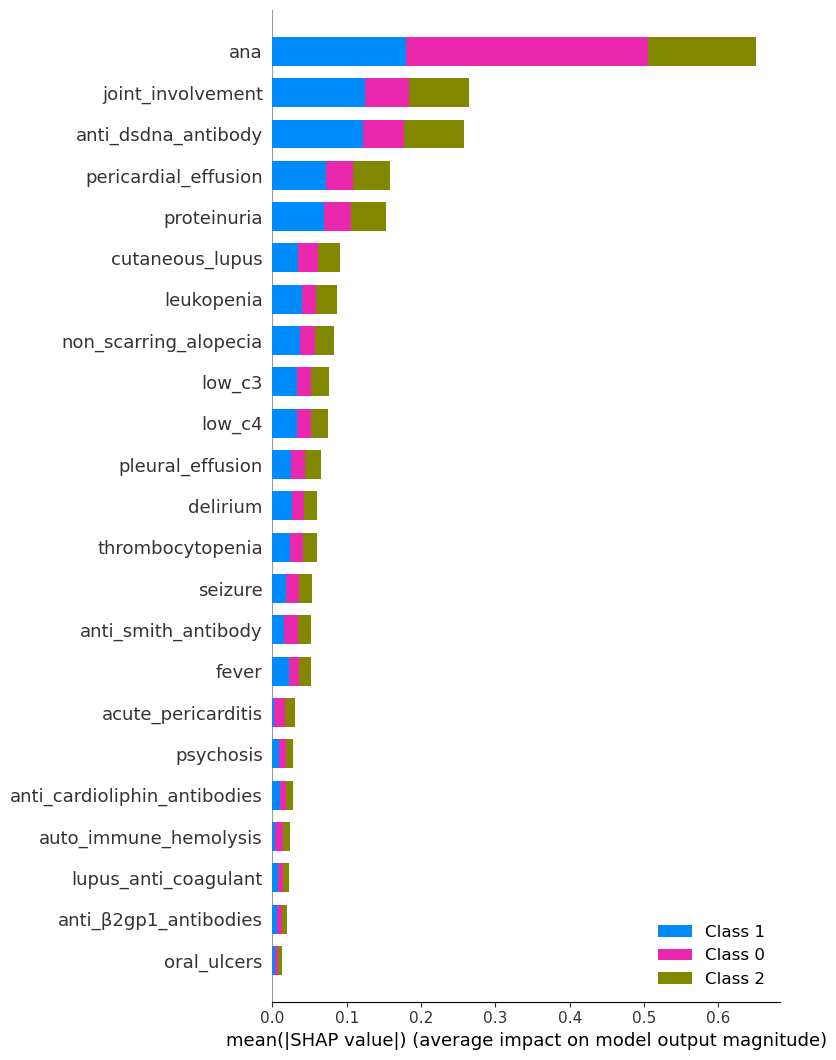

In [14]:
shap.summary_plot(shap_values, X_test, max_display=30)

#### Random Forest

In [15]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=constants.SEED).fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
test_df_rf = pd.DataFrame()
test_df_rf['y_actual'] = y_test
test_df_rf['y_pred'] = y_pred_rf
test_df_rf.isna().sum()

y_actual    0
y_pred      0
dtype: int64

In [16]:
# acc_rf, prec_rf, recall_rf, f1_rf = utils.test_binary(test_df_rf['y_actual'], test_df_rf['y_pred'])
# acc_rf, prec_rf, recall_rf, f1_rf 

In [17]:
acc_rf2, f1_rf2, roc_auc_rf2 = utils.test(test_df_rf['y_actual'], test_df_rf['y_pred'])
acc_rf2, f1_rf2, roc_auc_rf2

(96.34285714285714, 95.69639266276765, 97.03797933839628)

#### XGBoost

In [18]:
import xgboost as xgb
xg = xgb.XGBClassifier(random_state=constants.SEED).fit(X_train, y_train)
y_pred_xg = xg.predict(X_test)
test_df_xg = pd.DataFrame()
test_df_xg['y_actual'] = y_test
test_df_xg['y_pred'] = y_pred_xg
test_df_xg.isna().sum()

/home/lmuyama/anaconda3/envs/stable_baselines_3_env/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[21:38:59] WARNING: /croot/xgboost-split_1675119646044/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


y_actual    0
y_pred      0
dtype: int64

In [19]:
# acc_xg, prec_xg, recall_xg, f1_xg = utils.test_binary(test_df_xg['y_actual'], test_df_xg['y_pred'])
# acc_xg, prec_xg, recall_xg, f1_xg

In [20]:
acc_xg2, f1_xg2, roc_auc_xg2 = utils.test(test_df_xg['y_actual'], test_df_xg['y_pred'])
acc_xg2, f1_xg2, roc_auc_xg2

(97.87857142857142, 97.49160456090755, 98.41411503536195)